In [98]:
# Data Import
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm

import torch
from torchvision import models
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
import pytorch_lightning as pl

## Import Dataset

In [20]:
train_ds = MNIST("mnist", train=True, download=True, transform=ToTensor())
test_ds = MNIST("mnist", train=False, download=True, transform=ToTensor())

In [21]:
# Dataset short review
print("Train_shape: ", train_ds.data.shape)
print("Train_label_shape: ", train_ds.targets.shape)
print("Test_shape: ", test_ds.data.shape)

Train_shape:  torch.Size([60000, 28, 28])
Train_label_shape:  torch.Size([60000])
Test_shape:  torch.Size([10000, 28, 28])


In [22]:
labels = train_ds.targets
labels = pd.DataFrame(data=list(labels), columns=['label'])
labels['value'] = 1
labels_counts = labels.groupby('label').sum()
labels_counts

,value
label,
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851


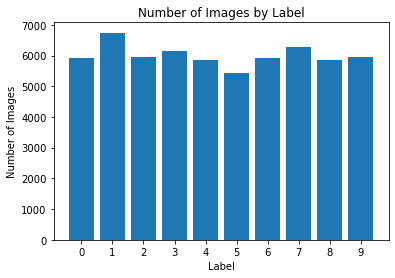

In [23]:
plt.bar(labels_counts.index, labels_counts.value)
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.xticks(list(labels_counts.index))
plt.title("Number of Images by Label")
plt.show()

Train data is equally distributed among labels

## Show sample images

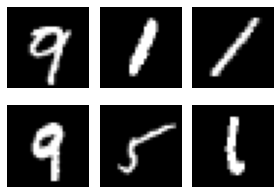

[9, 1, 1, 9, 5, 1]


In [24]:
# Show some randomly selected Train images and lables
import random

numImages = 6

random_index = np.random.choice(range(len(train_ds)), numImages)

plt.figure(figsize=(4,3))
plt.title("Some Random Training Images")
for i in range(numImages):
    plt.subplot(2,3,i+1)
    plt.imshow(train_ds.data[random_index[i]],cmap=plt.get_cmap("gray"))
    plt.axis("off")
plt.tight_layout()
plt.show() 

selected_lables = [train_ds.targets[idx].item() for idx in random_index]
print(selected_lables)

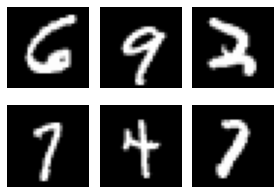

[6, 9, 2, 7, 4, 7]


In [25]:
random_index = np.random.choice(range(len(test_ds)), numImages)

plt.figure(figsize=(4,3))
plt.title("Some Random Testing Images")
for i in range(numImages):
    plt.subplot(2,3,i+1)
    plt.imshow(test_ds.data[random_index[i]],cmap=plt.get_cmap("gray"))
    plt.axis("off")
plt.tight_layout()
plt.show() 

selected_lables = [test_ds.targets[idx].item() for idx in random_index]
print(selected_lables)

Now, we see that train and test datasets have the same shapes and formats that we can work in the same way

## Build CNN Model

In [84]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
LR = 0.001
EPOCHS = 20
BATCH_SIZE = 64

In [35]:
model = models.resnet18(pretrained=False, num_classes=len(labels_counts))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
class ResnetMNIST(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.loss = nn.CrossEntropyLoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.accuracy(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

## Train MNIST with ResnetMNIST model

In [83]:
# One batch includes 64 images and labels
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [42]:
model = ResnetMNIST()

# Initialize a trainer
trainer = pl.Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=3,
    progress_bar_refresh_rate=20,
)

# Train the model ⚡
trainer.fit(model, train_dl)

/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val

Epoch 2: 100%|██████████| 938/938 [29:43<00:00,  1.90s/it, loss=0.0651, v_num=1]


In [43]:
trainer.save_checkpoint("resnet18_mnist.pt")

## Evaluated the Trained Model

In [44]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [45]:
from tqdm.autonotebook import tqdm

In [46]:
inference_model = ResNetMNIST.load_from_checkpoint("resnet18_mnist.pt")

In [47]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_dl), total=len(test_dl)):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())

100%|█████████████████████████████████████████| 157/157 [00:17<00:00,  8.93it/s]


In [48]:
from sklearn.metrics import classification_report

In [49]:
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.988     0.994     0.991       980
           1      0.960     0.997     0.978      1135
           2      0.995     0.958     0.976      1032
           3      0.979     0.989     0.984      1010
           4      0.956     0.999     0.977       982
           5      1.000     0.956     0.978       892
           6      0.991     0.982     0.986       958
           7      0.991     0.987     0.989      1028
           8      0.956     0.989     0.972       974
           9      0.994     0.946     0.970      1009

    accuracy                          0.980     10000
   macro avg      0.981     0.980     0.980     10000
weighted avg      0.981     0.980     0.980     10000



## Inferences

In [87]:
test_imgs, test_labels = next(iter(test_dl))
print(len(test_labels))

64


In [90]:
preds, probs = get_prediction(test_imgs, inference_model)

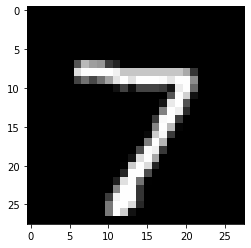

Predicted Label:  7
True Label:       7


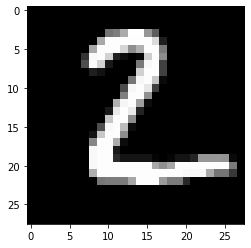

Predicted Label:  2
True Label:       2


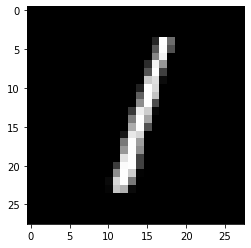

Predicted Label:  1
True Label:       1


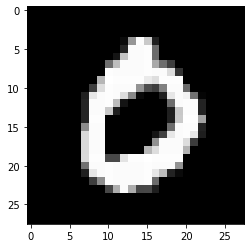

Predicted Label:  0
True Label:       0


In [97]:
for i in range(4):
    a_img = imgs[i].squeeze()
    a_label = labels[i]
    plt.imshow(a_img, cmap="gray")
    plt.show()
    print("Predicted Label: ", preds[i].item())
    print("True Label:      ", a_label.item())